In [ ]:
#autompg 

2025-04-01 10:32:09.618526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 10:32:09.626073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743483729.634954  127927 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743483729.637499  127927 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 10:32:09.646611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Dataset shape: (396, 7)
Columns: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model-year']
Features after one-hot encoding: 6

Testing m_mdn = 1
m_mdn 1, Epoch 100: Total Loss = 2.187790870666504
m_mdn 1, Epoch 200: Total Loss = 2.1875765323638916
m_mdn 1, Epoch 300: Total Loss = 2.1875758171081543
m_mdn 1, NLL = 2.168457508087158

Testing m_mdn = 2
m_mdn 2, Epoch 100: Total Loss = 1.8882237672805786
m_mdn 2, Epoch 200: Total Loss = 1.8879954814910889
m_mdn 2, Epoch 300: Total Loss = 1.887994408607483
m_mdn 2, NLL = 1.8688901662826538

Testing m_mdn = 3
m_mdn 3, Epoch 100: Total Loss = 1.988344430923462
m_mdn 3, Epoch 200: Total Loss = 1.9881179332733154
m_mdn 3, Epoch 300: Total Loss = 1.9881165027618408
m_mdn 3, NLL = 1.969008207321167

Testing m_mdn = 4
m_mdn 4, Epoch 100: Total Loss = 2.003838539123535
m_mdn 4, Epoch 200: Total Loss = 2.0036211013793945
m_mdn 4, Epoch 300: Total Loss = 2.003619909286499
m_mdn 4, NLL = 1.984547734260559

Testing m_md

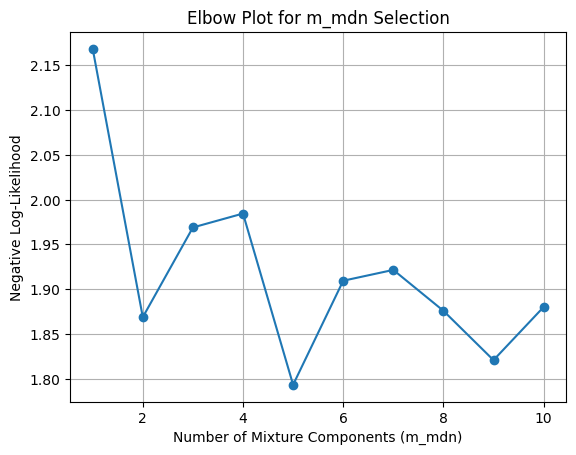

Selected m_mdn based on elbow method: 4

=== Run 1/10 ===
Run 1, Epoch 100: Total Loss = 1.8638789653778076
Run 1, Epoch 200: Total Loss = 1.8636982440948486
Run 1, Epoch 300: Total Loss = 1.8636977672576904

=== Run 2/10 ===
Run 2, Epoch 100: Total Loss = 1.813294529914856
Run 2, Epoch 200: Total Loss = 1.8130724430084229
Run 2, Epoch 300: Total Loss = 1.8130714893341064

=== Run 3/10 ===
Run 3, Epoch 100: Total Loss = 1.9863194227218628
Run 3, Epoch 200: Total Loss = 1.9861246347427368
Run 3, Epoch 300: Total Loss = 1.986124038696289

=== Run 4/10 ===
Run 4, Epoch 100: Total Loss = 1.9249372482299805
Run 4, Epoch 200: Total Loss = 1.9247455596923828
Run 4, Epoch 300: Total Loss = 1.9247448444366455

=== Run 5/10 ===
Run 5, Epoch 100: Total Loss = 1.906201720237732
Run 5, Epoch 200: Total Loss = 1.9060003757476807
Run 5, Epoch 300: Total Loss = 1.9059995412826538

=== Run 6/10 ===
Run 6, Epoch 100: Total Loss = 1.9618228673934937
Run 6, Epoch 200: Total Loss = 1.9615964889526367
Run 6

In [ ]:
import os
# Force TensorFlow to use CPU by disabling GPU and XLA devices.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
tf.config.optimizer.set_jit(False)

import numpy as np
import pandas as pd
import tensorflow_probability as tfp
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

----------------------- Metrics ------------------------- #
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def ece(y_true, y_pred, n_bins=10):
    if isinstance(y_true, tf.Tensor):
        y_true = y_true.numpy().flatten()
    else:
        y_true = y_true.flatten()
    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy().flatten()
    else:
        y_pred = y_pred.flatten()
        
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred, bin_edges, right=True) - 1
    ece_score = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if np.any(bin_mask):
            bin_true = y_true[bin_mask]
            bin_pred = y_pred[bin_mask]
            bin_acc = np.mean(bin_true)
            bin_conf = np.mean(bin_pred)
            ece_score += np.abs(bin_acc - bin_conf) * len(bin_true) / len(y_true)
    return ece_score

def nlpd(y_true, mu, sigma):
    return -np.mean(0.5 * np.log(2 * np.pi * sigma**2) + 0.5 * ((y_true - mu) / sigma)**2)

# ------------------------- Load Auto MPG Dataset ------------------------- #
# Load the dataset
data = pd.read_csv("/home/visdom/Downloads/auto-mpg.csv")
# Convert horsepower to numeric, coercing errors to NaN
data['horsepower'] = pd.to_numeric(data['horsepower'], errors='coerce')
# Drop rows with NaN in horsepower
data = data.dropna(subset=['horsepower'])
# Define features and target
X = data.drop(columns=['mpg']).copy()
y = data['mpg'].values
# One-hot encode categorical features
categorical_columns = X.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    X = pd.get_dummies(X, columns=categorical_columns)
X = X.values# --

# Print dataset info
print("Dataset shape:", data.shape)
print("Columns:", data.columns.tolist())
print("Features after one-hot encoding:", X.shape[1])

# ------------------------- Define Base Model ------------------------- #
class RFFLayer(tf.keras.layers.Layer):
    def __init__(self, S, kernel_widths, feature_count, random_state=42, **kwargs):
        super(RFFLayer, self).__init__(**kwargs)
        self.S = S
        self.feature_count = feature_count
        self.kernel_widths = tf.constant(kernel_widths, dtype=tf.float32)
        np.random.seed(random_state)
        self.Z = [tf.constant(np.random.normal(0, 1, (S, 1)), dtype=tf.float32)
                  for _ in range(feature_count)]
        self.c = tf.constant(np.random.uniform(0, 2 * np.pi, S), dtype=tf.float32)

    def call(self, inputs):
        transformed_features = []
        for i in range(self.feature_count):
            feature = tf.expand_dims(inputs[:, i], axis=1)
            prod = feature * tf.transpose(self.Z[i])
            prod = prod / self.kernel_widths[i]
            prod = prod + self.c
            transformed = tf.sqrt(2.0 / self.S) * tf.cos(prod)
            transformed_features.append(transformed)
        bias = tf.ones((tf.shape(inputs)[0], 1))
        return tf.concat([bias] + transformed_features, axis=1)

# Base model parameters
S_val = 100
feature_count = X.shape[1]  # Updated based on new X after one-hot encoding
kernel_widths = np.random.uniform(0.1, 2.0, feature_count)
rff_output_dim = 1 + feature_count * S_val

# ------------------------- Define MDN for Residuals ------------------------- #
class MDN(tf.keras.Model):
    def __init__(self, m_components):
        super(MDN, self).__init__()
        self.m_components = m_components
        self.hidden = tf.keras.layers.Dense(64, activation='relu')
        self.out = tf.keras.layers.Dense(3 * m_components)

    def call(self, x):
        h = self.hidden(x)
        output = self.out(h)
        out_mu = output[:, :self.m_components]
        out_sigma = output[:, self.m_components:2*self.m_components]
        out_alpha = output[:, 2*self.m_components:]
        sigma = tf.exp(out_sigma)
        alpha = tf.nn.softmax(out_alpha, axis=-1)
        return tf.concat([out_mu, sigma, alpha], axis=1)

def mdn_loss_fn(y_true, mdn_params, m_components):
    out_mu = mdn_params[:, :m_components]
    out_sigma = mdn_params[:, m_components:2*m_components]
    out_alpha = mdn_params[:, 2*m_components:]
    sigma = tf.exp(out_sigma)
    alpha = tf.nn.softmax(out_alpha, axis=-1)
    
    y_true = tf.reshape(y_true, [-1, 1])
    dist = tfp.distributions.Normal(loc=out_mu, scale=sigma)
    probs = dist.prob(y_true)
    weighted_probs = alpha * probs
    prob = tf.reduce_sum(weighted_probs, axis=1, keepdims=True)
    nll = -tf.math.log(prob + 1e-8)
    return tf.reduce_mean(nll)

# ------------------------- Learning Rate Schedule ------------------------- #
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, total_steps, final_lr=1e-6):
        super(WarmUpCosineDecay, self).__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.final_lr = final_lr

    def __call__(self, i):
        i = tf.cast(i, tf.float32)
        lr_warmup = self.initial_lr * (i / tf.cast(self.warmup_steps, tf.float32))
        progress = (i - tf.cast(self.warmup_steps, tf.float32)) / tf.cast(self.total_steps - self.warmup_steps, tf.float32)
        lr_cosine = self.final_lr + 0.5 * (self.initial_lr - self.final_lr) * (1 + tf.cos(np.pi * progress))
        return tf.cond(i < self.warmup_steps, lambda: lr_warmup, lambda: lr_cosine)

total_steps = 300
warmup_steps = 100
lr_schedule = WarmUpCosineDecay(initial_lr=0.005, warmup_steps=warmup_steps, total_steps=total_steps, final_lr=1e-6)

# ------------------------- Elbow Method to Select m_mdn ------------------------- #
# Split data for elbow method (use a fixed split for consistency)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_temp_scaled = scaler_X.fit_transform(X_temp)
X_test_scaled = scaler_X.transform(X_test)
y_temp_scaled = scaler_y.fit_transform(y_temp.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Test different m_mdn values
m_mdn_candidates = range(1, 11)  # Test m_mdn from 1 to 10
nll_scores = []

for m_mdn in m_mdn_candidates:
    print(f"\nTesting m_mdn = {m_mdn}")
    
    # Reinitialize models for each m_mdn
    rff_layer = RFFLayer(S_val, kernel_widths, feature_count, random_state=0)
    w = tf.Variable(tf.zeros((rff_output_dim, 1)), dtype=tf.float32)
    mdn_model = MDN(m_components=m_mdn)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    all_trainable = [w] + list(rff_layer.trainable_variables) + list(mdn_model.trainable_variables)

    @tf.function
    def train_step(X_batch, y_batch):
        with tf.GradientTape() as tape:
            base_pred = tf.matmul(rff_layer(X_batch), w)
            loss_base = 0.5 * tf.reduce_mean(tf.square(y_batch - base_pred)) + 0.5 * tf.nn.l2_loss(w)
            residual = y_batch - base_pred
            mdn_params = mdn_model(X_batch)
            loss_mdn = mdn_loss_fn(residual, mdn_params, m_components=m_mdn)
            total_loss = loss_base + loss_mdn
        gradients = tape.gradient(total_loss, all_trainable)
        optimizer.apply_gradients(zip(gradients, all_trainable))
        return total_loss

    # Train the model
    for epoch in range(1, total_steps + 1):
        loss_val = train_step(tf.convert_to_tensor(X_temp_scaled, dtype=tf.float32),
                              tf.convert_to_tensor(y_temp_scaled, dtype=tf.float32))
        if epoch % 100 == 0:
            print(f"m_mdn {m_mdn}, Epoch {epoch}: Total Loss = {loss_val.numpy()}")

    # Compute NLL on training data
    base_pred_temp = tf.matmul(rff_layer(tf.convert_to_tensor(X_temp_scaled, dtype=tf.float32)), w)
    residual_temp = tf.convert_to_tensor(y_temp_scaled, dtype=tf.float32) - base_pred_temp
    mdn_params_temp = mdn_model(tf.convert_to_tensor(X_temp_scaled, dtype=tf.float32))
    nll = mdn_loss_fn(residual_temp, mdn_params_temp, m_components=m_mdn).numpy()
    nll_scores.append(nll)
    print(f"m_mdn {m_mdn}, NLL = {nll}")

# Plot NLL vs m_mdn
plt.plot(m_mdn_candidates, nll_scores, marker='o')
plt.xlabel('Number of Mixture Components (m_mdn)')
plt.ylabel('Negative Log-Likelihood')
plt.title('Elbow Plot for m_mdn Selection')
plt.grid(True)
plt.show()

# Select m_mdn based on the elbow (manual inspection or heuristic)
relative_improvements = np.abs(np.diff(nll_scores) / nll_scores[:-1])
threshold = 0.05  # Consider the elbow where improvement is less than 5%
elbow_idx = np.where(relative_improvements < threshold)[0][0] if any(relative_improvements < threshold) else len(m_mdn_candidates) - 1
best_m_mdn = m_mdn_candidates[elbow_idx + 1] if elbow_idx < len(m_mdn_candidates) - 1 else m_mdn_candidates[elbow_idx]
print(f"Selected m_mdn based on elbow method: {best_m_mdn}")

# ------------------------- Joint End-to-End Training with Selected m_mdn ------------------------- #
num_runs = 10
results = []

# Use the selected m_mdn for the final training
m_mdn = best_m_mdn

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    
    # Train-test split and scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=run)
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
    
    # Reinitialize models
    rff_layer = RFFLayer(S_val, kernel_widths, feature_count, random_state=0)
    w = tf.Variable(tf.zeros((rff_output_dim, 1)), dtype=tf.float32)
    mdn_model = MDN(m_components=m_mdn)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    all_trainable = [w] + list(rff_layer.trainable_variables) + list(mdn_model.trainable_variables)

    @tf.function
    def train_step(X_batch, y_batch):
        with tf.GradientTape() as tape:
            base_pred = tf.matmul(rff_layer(X_batch), w)
            loss_base = 0.5 * tf.reduce_mean(tf.square(y_batch - base_pred)) + 0.5 * tf.nn.l2_loss(w)
            residual = y_batch - base_pred
            mdn_params = mdn_model(X_batch)
            loss_mdn = mdn_loss_fn(residual, mdn_params, m_components=m_mdn)
            total_loss = loss_base + loss_mdn
        gradients = tape.gradient(total_loss, all_trainable)
        optimizer.apply_gradients(zip(gradients, all_trainable))
        return total_loss

    for epoch in range(1, total_steps + 1):
        loss_val = train_step(tf.convert_to_tensor(X_train_scaled, dtype=tf.float32),
                              tf.convert_to_tensor(y_train_scaled, dtype=tf.float32))
        if epoch % 100 == 0:
            print(f"Run {run+1}, Epoch {epoch}: Total Loss = {loss_val.numpy()}")
    
    # ------------------------- Evaluation ------------------------- #
    X_test_tf = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
    base_pred_test = tf.matmul(rff_layer(X_test_tf), w)
    mdn_params_test = mdn_model(X_test_tf)
    
    out_mu = mdn_params_test[:, :m_mdn]
    out_sigma = tf.exp(mdn_params_test[:, m_mdn:2*m_mdn])
    out_alpha = tf.nn.softmax(mdn_params_test[:, 2*m_mdn:], axis=-1)
    
    mdn_res_mean = tf.reduce_sum(out_mu * out_alpha, axis=1, keepdims=True)
    mdn_res_var = tf.reduce_sum(out_alpha * (out_sigma**2 + out_mu**2), axis=1, keepdims=True) - mdn_res_mean**2
    
    y_pred_test = base_pred_test + mdn_res_mean
    
    run_rmse = rmse(tf.convert_to_tensor(y_test_scaled, dtype=tf.float32), y_pred_test).numpy()
    run_ece = ece(y_test_scaled, y_pred_test.numpy())
    run_nlpd = nlpd(y_test_scaled, y_pred_test.numpy(), np.sqrt(mdn_res_var.numpy()))
    
    results.append({
        "rmse": run_rmse,
        "ece": run_ece,
        "nlpd": run_nlpd
    })

# ------------------------- Print Final Metrics ------------------------- #
rmse_vals = [res["rmse"] for res in results]
ece_vals = [res["ece"] for res in results]
nlpd_vals = [res["nlpd"] for res in results]

print("\nFinal Results over 10 runs:")
print(f"Test RMSE: {np.mean(rmse_vals):.4f} ± {np.std(rmse_vals):.4f}")
print(f"Test ECE:  {np.mean(ece_vals):.4f} ± {np.std(ece_vals):.4f}")
print(f"Test NLPD: {np.mean(nlpd_vals):.4f} ± {np.std(nlpd_vals):.4f}")